In [1]:
import numpy as np
import cv2
from emperorviopy.common.ThreadedCamera import ThreadedCamera
from emperorviopy.common.CameraModel import PinholeCamera
from glob import glob
from matplotlib import pyplot as plt

In [2]:
# Camera Setup
left_cam_index = 2
right_cam_index = 4
cam_left_calibration_file = 'Project/CALIB/logicamB.yaml'
cam_right_calibration_file = 'Project/CALIB/logicamA.yaml'

width_val = 800
height_val = 600
# camL = ThreadedCamera(int(cam_left_index), width_val, height_val)
camLP = PinholeCamera.loadFromOST(cam_left_calibration_file)
# camR = ThreadedCamera(int(cam_right_index), width_val, height_val)
camRP = PinholeCamera.loadFromOST(cam_right_calibration_file)

In [3]:
# Image setup
# images_left_fns = sorted(glob('OUTPUT/left2/*'))
# images_right_fns = sorted(glob('OUTPUT/right2/*'))
# images_left_fns = sorted(glob('OUTPUT/mapleft/*'))
# images_right_fns = sorted(glob('OUTPUT/mapright/*'))
images_left_fns = sorted(glob('scrubbedOut/left/*'))
images_right_fns = sorted(glob('scrubbedOut/right/*'))

stereo_fns = [(images_left_fns[i], images_right_fns[i]) for i in range(len(images_left_fns))]
print(stereo_fns[0])
stereo_imgs = [(cv2.imread(img_fn[0], cv2.IMREAD_GRAYSCALE), cv2.imread(img_fn[1], cv2.IMREAD_GRAYSCALE)) for img_fn in stereo_fns]


# Stereo Matcher
minDisparity = 9
numDisparities = 1 * 16
blocksize = 1 * 2 + 5

stereo = cv2.StereoSGBM_create()
# stereo = cv2.StereoBM_create()
stereo.setNumDisparities(numDisparities)
stereo.setBlockSize(blocksize)
# stereo.setPreFilterType(1)
# stereo.setPreFilterSize(2 * 2 + 5)
# stereo.setPreFilterCap(5)
# stereo.setTextureThreshold(10)
stereo.setUniquenessRatio(0)
stereo.setSpeckleRange(5)
stereo.setSpeckleWindowSize(0 * 2)
stereo.setDisp12MaxDiff(25)
stereo.setMinDisparity(minDisparity)


# DisparityFilter
wsize = 31
max_disp = 128
right_matcher = cv2.ximgproc.createRightMatcher(stereo)
wls_filter = cv2.ximgproc.createDisparityWLSFilter(stereo)

def get_stereo_pair(index):
    return stereo_imgs[index][0].copy(), stereo_imgs[index][1].copy()

def disparity_compute(l, r):
    disp = stereo.compute(l, r)
    disp = disp.astype(np.float32)
    return (disp/16.0 - minDisparity)/numDisparities

def filtered_disparity_compute(l, r, sigma=1.5, lmbda=8000.0):
    left_disp = stereo.compute(l, r)
    right_disp = right_matcher.compute(r, l)
    wls_filter.setLambda(lmbda)
    wls_filter.setSigmaColor(sigma)
    return wls_filter.filter(
        left_disp, l, disparity_map_right=right_disp)

# now we undistort each image
undistorted_imgs = [(cv2.undistort(simg[0], camLP.camera_matrix, camLP.d), cv2.undistort(simg[1], camRP.camera_matrix, camRP.d)) for simg in stereo_imgs]

def get_undistorted_pair(index):
    return undistorted_imgs[index][0].copy(), undistorted_imgs[index][1].copy()


('scrubbedOut/left/21_left.png', 'scrubbedOut/right/21_right.png')


In [4]:
index = 1

In [5]:
# l,r = get_stereo_pair(index)
# plt.imshow(np.hstack((l, r)), cmap='gray')
# plt.show()
# disparity = disparity_compute(l, r)
# plt.imshow(disparity, cmap='gray')
# plt.show()

In [6]:
# # showing undistortion (basic diff)
# sl, sr = get_stereo_pair(index)
# l, r = get_undistorted_pair(index)
# b = sr != r
# plt.imshow(b, cmap='gray')

In [7]:
# l,r = get_undistorted_pair(index)
# plt.imshow(np.hstack((l, r)), cmap='gray')
# plt.show()
# disparity = disparity_compute(l, r)
# plt.imshow(disparity, cmap='gray')
# plt.show()

In [8]:
#cam2 = right camera
translation_of_cam2 = np.array([-74.466074860268400, -0.627470098358044, -4.156235117962683])
rotation_of_cam2 = np.array([
        [0.999656627059769, -0.005228656941179, -0.025676625987035],
        [0.005345256704269, 1.0000, 0.004474551572321],
        [0.025652606227284, -0.004610263289592, 0.999660286930590]])

# translation_of_cam2 = translation_of_cam2[np.newaxis].transpose()
t_camera2_camera1 = np.dot(-rotation_of_cam2.transpose(), translation_of_cam2)
R_camera2_camera1 = rotation_of_cam2.transpose()

# Stereo rectification step
l, r = get_stereo_pair(index)
flags = cv2.CALIB_ZERO_DISPARITY
image_size = (600,800)
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(camLP.camera_matrix, camLP.d, camRP.camera_matrix, camRP.d, image_size, rotation_of_cam2, translation_of_cam2, flags=flags, alpha=0)
# R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(camLP.camera_matrix, camLP.d, camRP.camera_matrix, camRP.d, image_size, R_camera2_camera1, t_camera2_camera1, flags=flags)


# init rectificationmap
leftmapX, leftmapY = cv2.initUndistortRectifyMap(camLP.camera_matrix, camLP.d, R1, P1, image_size, cv2.CV_32FC1)
rightmapX, rightmapY = cv2.initUndistortRectifyMap(camRP.camera_matrix, camRP.d, R2, P2, image_size, cv2.CV_32FC1)

# Remap
# left_remap =cv2.remap(l, leftmapX, leftmapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
# right_remap =cv2.remap(r, rightmapX, rightmapY, cv2.INTER_LANCZOS4, cv2.BORDER_CONSTANT, 0)
left_remap =cv2.remap(l, leftmapX, leftmapY, cv2.INTER_LINEAR)
right_remap =cv2.remap(r, rightmapX, rightmapY, cv2.INTER_LINEAR)


 (800, 600), (800, 600)
imgL: (800, 600) : (0, 0, 600, 800)
imgR: (800, 600) : (1, 0, 599, 800)


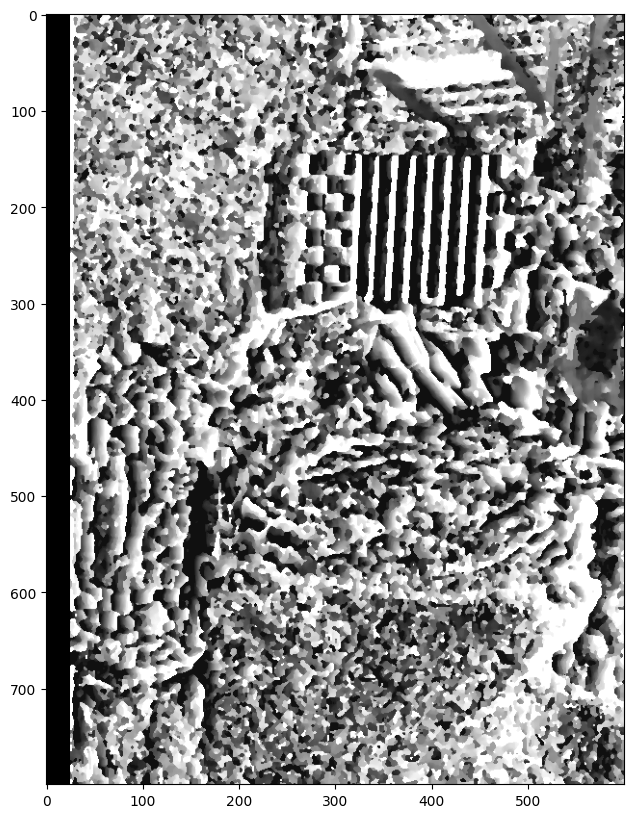

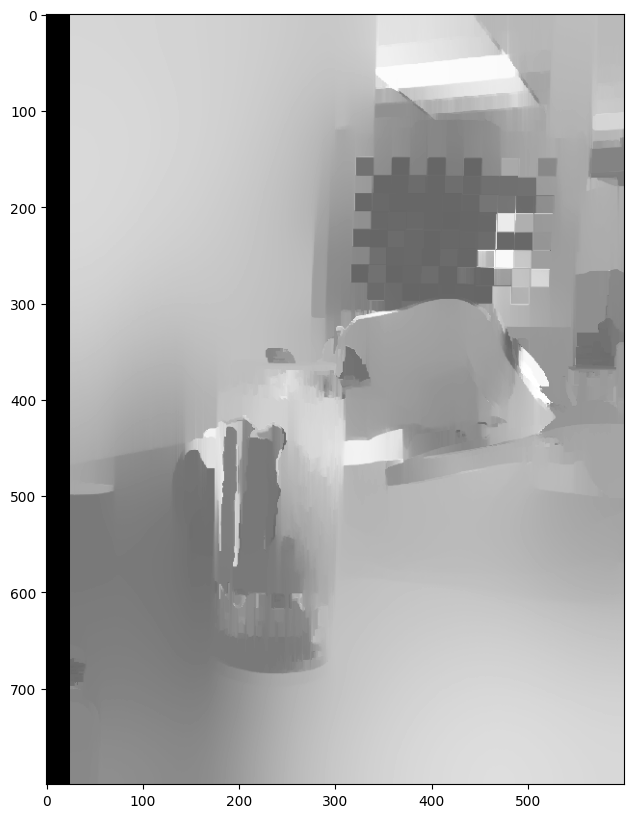

In [9]:
left_remap_lined = left_remap.copy()
right_remap_lined = right_remap.copy()
print(f" {left_remap_lined.shape}, {right_remap_lined.shape}")
for line in range(0, int(right_remap.shape[0] / 20)):
    left_remap_lined[line * 20, :] = 0
    right_remap_lined[line * 20, :] = 0
left_remap_lined = cv2.rectangle(left_remap_lined, (roi1[0], roi1[1]), (roi1[2], roi1[3]), (255,0,0), 2)
right_remap_lined = cv2.rectangle(right_remap_lined, (roi2[0], roi2[1]), (roi2[2], roi2[3]), (255,0,0), 2)
print(f"imgL: {left_remap_lined.shape} : {roi1}")
print(f"imgR: {right_remap_lined.shape} : {roi2}")

# fig = plt.figure(figsize=(15,15))-
# plt.subplots(figsize=(14,14))
# plt.imshow(np.hstack((left_remap_lined, right_remap_lined)), cmap='gray')
# plt.show()
plt.subplots(figsize=(10,10))
plt.imshow(disparity_compute(left_remap, right_remap), cmap='gray')
plt.show()
filtered_disp = filtered_disparity_compute(left_remap, right_remap, 3, 8000)
plt.subplots(figsize=(10,10))
plt.imshow(filtered_disp, cmap='gray')
plt.show()

In [14]:
# Debug showing in opencv.
cvshow = cv2.ximgproc.getDisparityVis(filtered_disp)
# cvshow = filtered_disp.astype(np.float32)
# cvshow =  (cvshow/256).astype(np.uint8)
cvshow = cv2.applyColorMap(cvshow, cv2.COLORMAP_JET)

cv2.imshow('disp', cvshow)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02
# https://stackoverflow.com/questions/41503561/whats-the-difference-between-reprojectimageto3dopencv-and-disparity-to-3d-coo
# reprojectImageTo3D()